In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score,r2_score, roc_auc_score, recall_score,confusion_matrix
import os
import matplotlib.pyplot as plt
import shap

In [59]:
def get_shap(X, target, rank_range=5):
    """
    Процедура визуализации интерпритации моделей.
    Строим шапы и депенденсы для нашей выборки.
    """
    fig, ax = plt.subplots(1, figsize=(10, 15))
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, show=False)
    fig, ax = plt.subplots(1, figsize=(10, 15))
    shap.summary_plot(shap_values, X, plot_type="bar")
    for i in range(0,rank_range):
        shap.dependence_plot('rank('+str(i)+')', shap_values, X, show=False)
        


In [47]:
df = pd.read_csv('MLPP_ML_2021.csv')
df

,ID,Name,Region,Churn,Z_score,Pribor,VKK,Count_results,cycle,True_results,Calibration,EQAS,FSVOK
0,Б1,"ГБУЗ ""Ленинградская областная клиническая боль...",Приволжский ФО,1,1.630813,ручной_анализ,0,11,6,36,1,1,1
1,Б2_1,"СПб ГБУЗ ""Консультативно-диагностический центр...",Приволжский ФО,1,1.614549,полуавтомат,1,18,4,30,1,1,1
2,Б2_2,"СПб ГБУЗ ""Консультативно-диагностический центр...",Приволжский ФО,1,1.228905,полуавтомат,1,9,6,45,1,0,0
3,Б3,"СПб ГБУЗ ""Городская поликлиника №91""",Приволжский ФО,1,1.310005,ручной_анализ,0,23,8,41,0,1,1
4,Б4_1,СПб ГБУЗ ГБ №26 Анализатор Taurus u2...,Приволжский ФО,1,1.172678,полуавтомат,0,15,4,23,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,С79,"ОГБУЗ ""Черемховская городская больница №1""",Южный ФО,0,0.829153,полуавтомат,0,23,8,82,1,0,0
559,С80,ФГБУЗ Центральная медико-санитарная часть №28 ...,Южный ФО,0,1.030531,автомат_анализатор,1,30,8,49,1,1,1
560,С81,"ОГБУЗ «Областная больница №2», п. Усть-Ордынский",Южный ФО,0,0.908902,полуавтомат,1,34,3,48,1,1,1
561,С82,Тюменская больница ФГБУЗ «Западно-Сибирский ме...,Южный ФО,0,1.239600,ручной_анализ,1,23,7,42,1,1,0


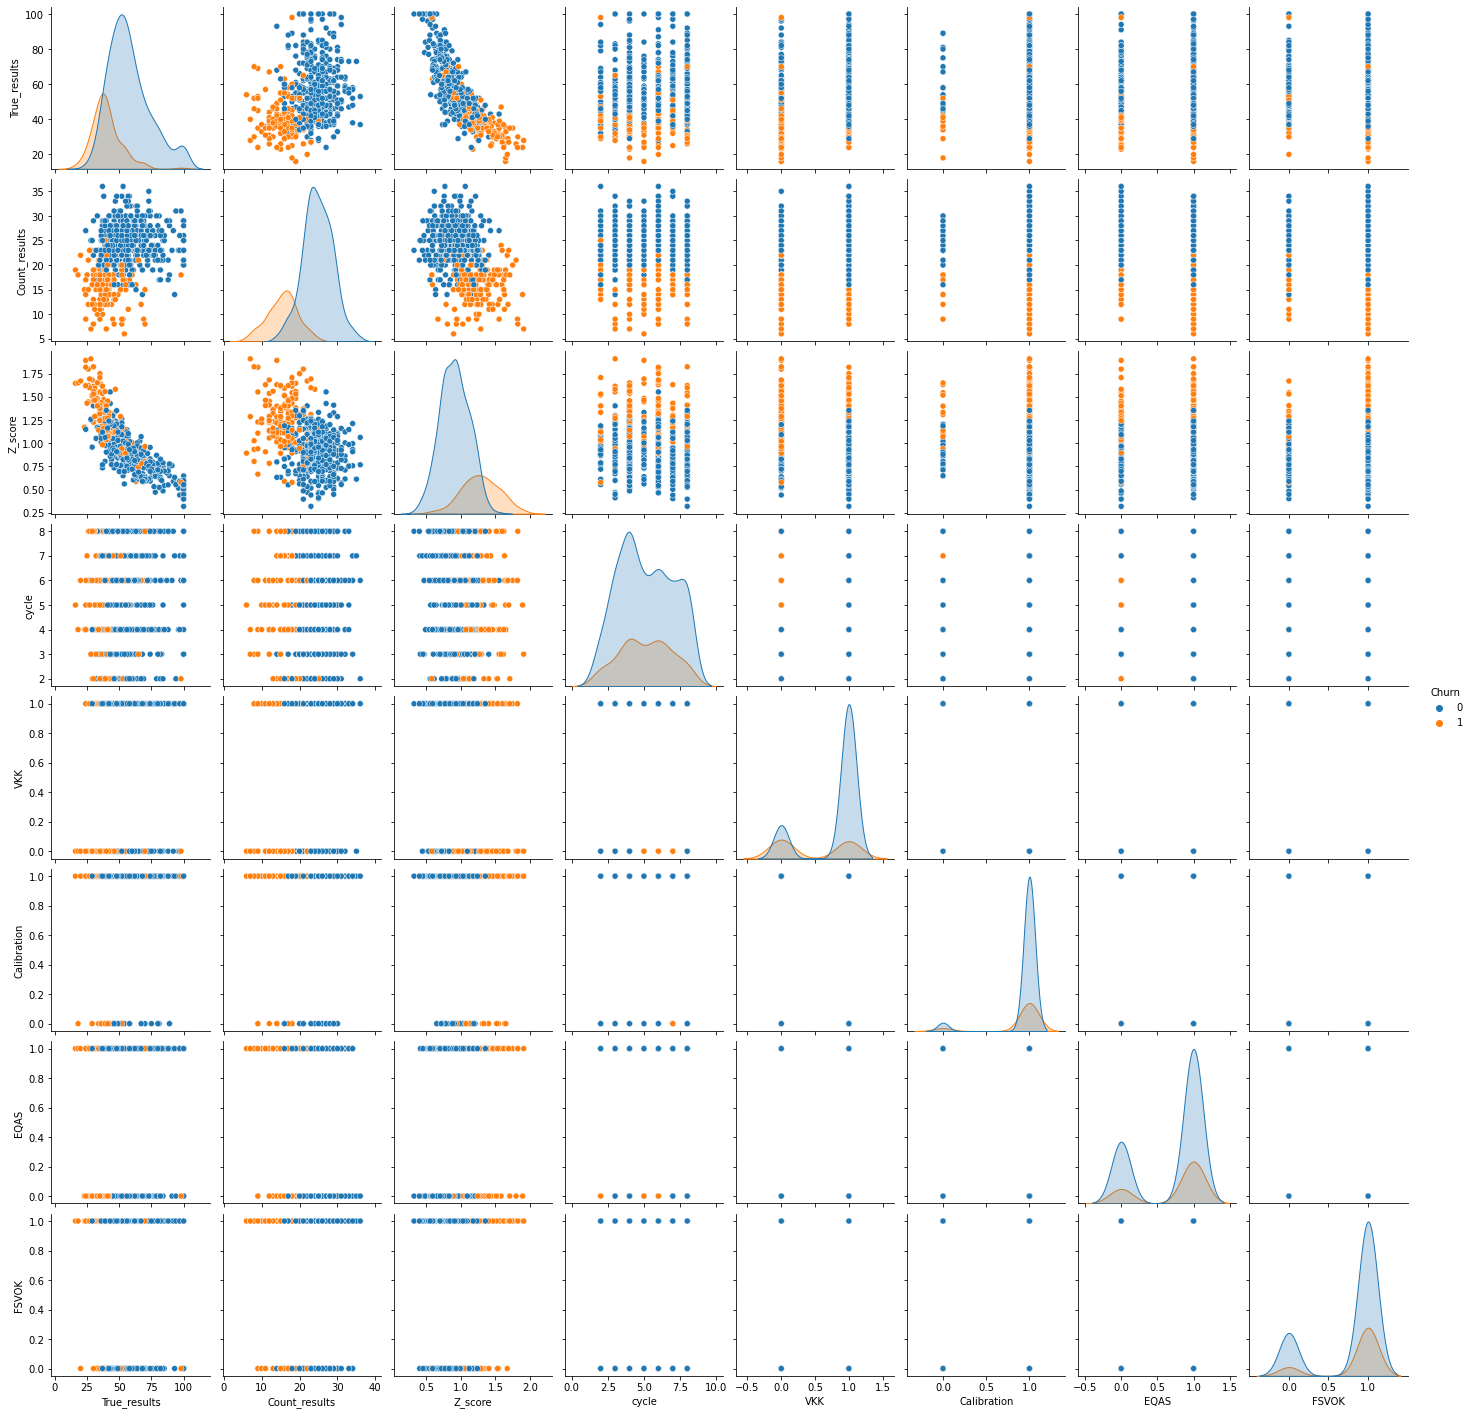

In [48]:
# Разделяем переменный на числовые и категориальные, Выделяем таргет. 
# Строим попарные графики, чтобы увидеть общую картину по данным
num_col = [ 'True_results', 'Count_results', 'Z_score', 'cycle']
cat_col = ['Region','Pribor','VKK','Calibration', 'EQAS', 'FSVOK']
target = 'Churn'
sns.pairplot(df[num_col + cat_col + [target]], hue=target)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Churn
Train count / churn 422 / 102
Test count / churn 141 / 34
Matrix 
 [[102   0]
 [  5  34]]
f1_score 0.9315068493150686
accuracy_score 0.9645390070921985
roc_auc_score 0.9766355140186915
recall_score {recall_score(y_test, y_pred_test)}
      Feature Id  Importances
0  Count_results    40.501791
1         Pribor    22.729245
2        Z_score    14.369636
3         Region     9.136654
4   True_results     5.663603
5          cycle     4.418803
6            VKK     1.951804
7           EQAS     0.838112
8          FSVOK     0.369593
9    Calibration     0.020759


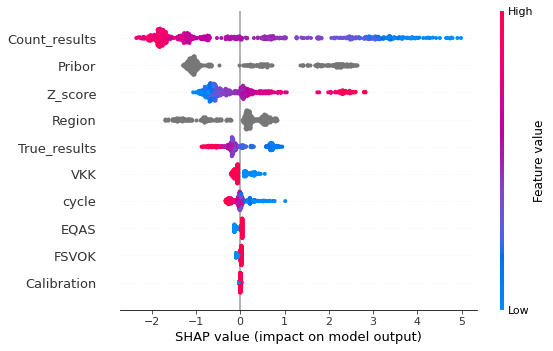

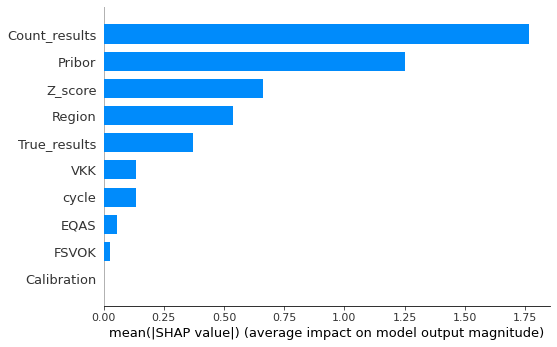

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


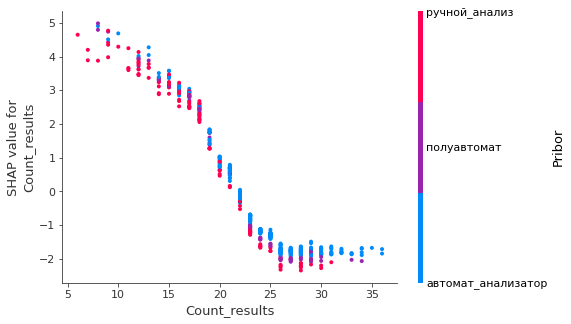

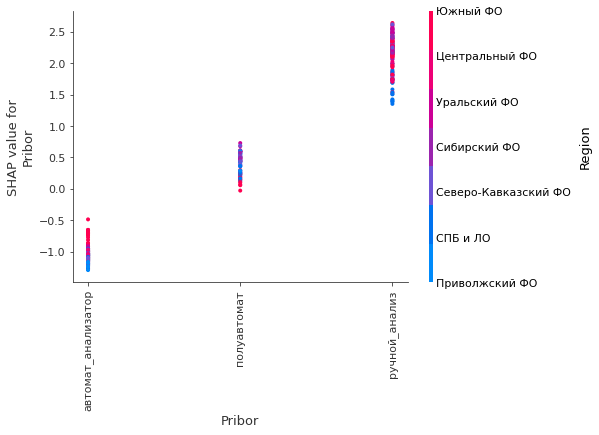

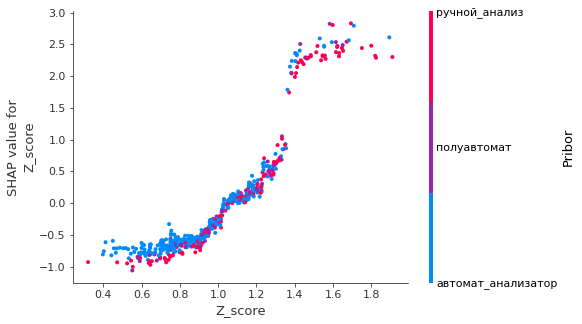

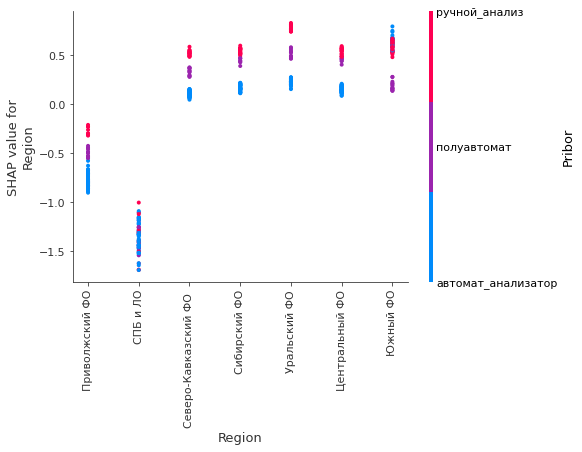

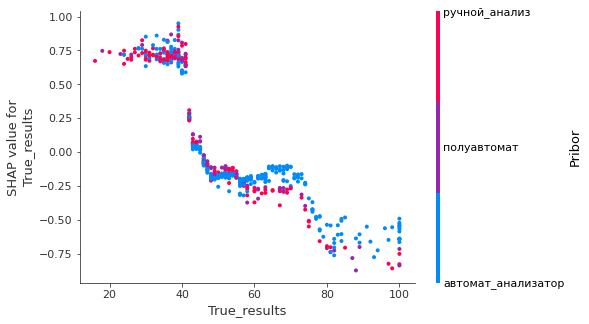

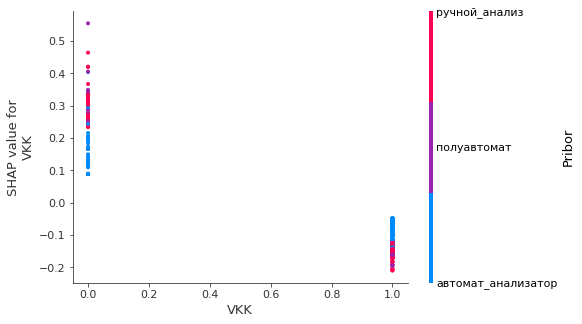

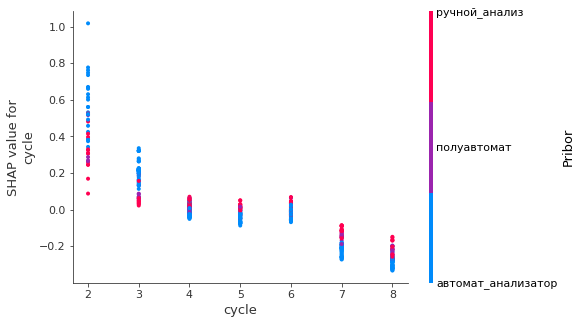

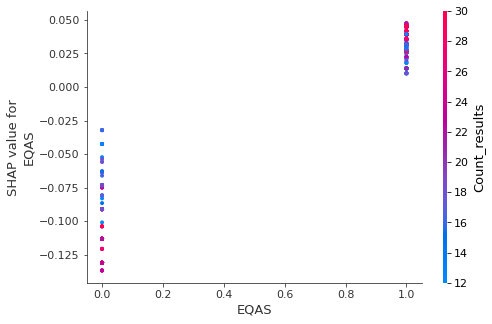

In [63]:
# Сторим модель классификатора 
# Поскольку у нас много категориальных переменных, то используем CatBoost.

# Разбиваем данные на тест и трейн. Важно, т.к. у нас дисбаланс классов, то делаем stratify
X_train, X_test,y_train, y_test = train_test_split(df[num_col + cat_col], df[target],stratify = df[target] )
# Определяем классификатор, обязательно контролируем веса классов
clf = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=3,cat_features = cat_col, class_weights=[1,round(1/df[target].mean(), 1)])
# Во время обучения смотрим на изменение ошибки на тесте. 
clf.fit(X_train, y_train
                  ,eval_set = Pool(X_test, y_test, cat_features = cat_col)
                  ,plot=True
                  ,verbose = False
                  ,use_best_model=True)

y_pred_test = clf.predict(X_test)
# Собираем метрики
line = target + '\n'
line += f'Train count / churn { y_train.count()} / { y_train.sum()}\n'
line += f'Test count / churn { y_test.count()} / { y_test.sum()}\n'
line += f'Matrix \n {confusion_matrix(y_pred_test,y_test)}\n'
line += f"f1_score {f1_score(y_pred_test,y_test)}\n"
line+= f"accuracy_score {accuracy_score(y_pred_test,y_test)}\n" 
line += f"roc_auc_score {roc_auc_score(y_test, y_pred_test)}\n"
line +="recall_score {recall_score(y_test, y_pred_test)}\n" 
line += f'{clf.get_feature_importance(prettified=True)}'
print(line)
get_shap(df[num_col + cat_col], target, rank_range=8)